In [1]:
#import numpy, pandas and plotting tools
import numpy as np                   
import pandas as pd                  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import mean, correlate, cov

# Import regression tools & CV tools
%config Completer.use_jedi = False  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [2]:
#change maximum number of rows and columns
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999

In [3]:
#import data
df = pd.read_csv('ipf_2023.csv')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              367 non-null    object 
 1   Sex               367 non-null    object 
 2   Event             367 non-null    object 
 3   Equipment         367 non-null    object 
 4   Age               367 non-null    float64
 5   AgeClass          367 non-null    object 
 6   BirthYearClass    367 non-null    object 
 7   Division          367 non-null    object 
 8   BodyweightKg      367 non-null    float64
 9   WeightClassKg     367 non-null    object 
 10  Squat1Kg          367 non-null    float64
 11  Squat2Kg          364 non-null    float64
 12  Squat3Kg          362 non-null    float64
 13  Squat4Kg          0 non-null      float64
 14  Best3SquatKg      367 non-null    float64
 15  Bench1Kg          367 non-null    float64
 16  Bench2Kg          366 non-null    float64
 1

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,Mara Hames,F,SBD,Raw,25.0,24-34,24-39,Open,75.10,76,175.0,182.5,-190.0,NaN,182.5,95.0,100.0,-105.0,NaN,100.0,177.5,185.0,190.0,NaN,190.0,472.5,17,459.88,448.80,394.77,93.69,Yes,Germany,NaN,IPF,IPF,2023-06-11,Malta,NaN,St. Julians,World Classic Powerlifting Championships
1,Monica de La Torre,F,SBD,Raw,27.5,24-34,24-39,Open,51.85,52,125.0,132.5,135.0,NaN,135.0,90.0,92.5,95.0,NaN,95.0,150.0,160.0,-165.0,NaN,160.0,390.0,11,476.33,487.27,431.97,98.72,Yes,Mexico,NaN,IPF,IPF,2023-06-11,Malta,NaN,St. Julians,World Classic Powerlifting Championships
2,Martina Malzová,F,SBD,Raw,27.5,24-34,24-39,Open,51.65,52,122.5,127.5,132.5,NaN,132.5,65.0,-67.5,67.5,NaN,67.5,165.0,172.5,-177.5,NaN,172.5,372.5,13,456.18,466.80,413.88,94.61,Yes,Czechia,NaN,IPF,IPF,2023-06-11,Malta,NaN,St. Julians,World Classic Powerlifting Championships
3,Miriam Amri,F,SBD,Raw,27.5,24-34,24-39,Open,56.70,57,147.5,157.5,-162.5,NaN,157.5,77.5,82.5,-85.0,NaN,82.5,182.5,192.5,-197.5,NaN,192.5,432.5,9,497.23,503.95,445.65,101.85,Yes,Netherlands,NaN,IPF,IPF,2023-06-11,Malta,NaN,St. Julians,World Classic Powerlifting Championships
4,Mayara Soares,F,SBD,Raw,30.5,24-34,24-39,Open,46.70,47,117.5,125.0,-130.0,NaN,125.0,62.5,65.0,67.5,NaN,67.5,122.5,130.0,135.0,NaN,135.0,327.5,11,431.25,442.49,394.65,91.36,Yes,Brazil,NaN,IPF,IPF,2023-06-11,Malta,NaN,St. Julians,World Classic Powerlifting Championships


In [4]:
#clean data
df = df[df['Sex'] == 'F']
df = df[df['Best3SquatKg'] > 0] 
df = df[df['Best3BenchKg'] > 0]
df = df[df['Best3DeadliftKg'] > 0]
df = df[df['MeetName'] == 'World Classic Powerlifting Championships']

df = df[['Name','Sex', 'Age', 'AgeClass', 'BodyweightKg','WeightClassKg', 'TotalKg', 'Place','Dots','Wilks']]
df.head(5)

,Name,Sex,Age,AgeClass,BodyweightKg,WeightClassKg,TotalKg,Place,Dots,Wilks
0,Mara Hames,F,25.0,24-34,75.10,76,472.5,17,459.88,448.80
1,Monica de La Torre,F,27.5,24-34,51.85,52,390.0,11,476.33,487.27
2,Martina Malzová,F,27.5,24-34,51.65,52,372.5,13,456.18,466.80
3,Miriam Amri,F,27.5,24-34,56.70,57,432.5,9,497.23,503.95
4,Mayara Soares,F,30.5,24-34,46.70,47,327.5,11,431.25,442.49


Name             Zoé Coinne
Sex                       F
Age                   75.00
AgeClass              75-79
BodyweightKg         152.75
WeightClassKg           84+
TotalKg              693.50
Place                     9
Dots                 600.18
Wilks                604.70
dtype: object
Name             Adejoke Adetayo
Sex                            F
Age                        20.50
AgeClass                   20-23
BodyweightKg               45.35
WeightClassKg                 47
TotalKg                   217.50
Place                          1
Dots                      279.82
Wilks                     287.18
dtype: object


,Age,BodyweightKg,TotalKg,Dots,Wilks
Age,1.00,-0.03,-0.24,-0.34,-0.34
BodyweightKg,-0.03,1.00,0.72,0.01,-0.09
TotalKg,-0.24,0.72,1.00,0.67,0.56
Dots,-0.34,0.01,0.67,1.00,0.99
Wilks,-0.34,-0.09,0.56,0.99,1.00


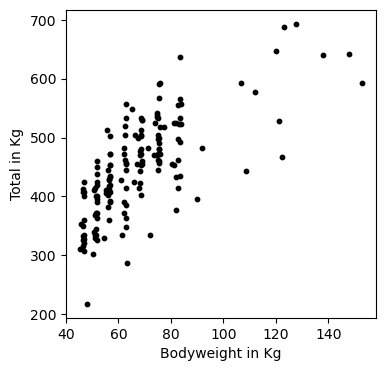

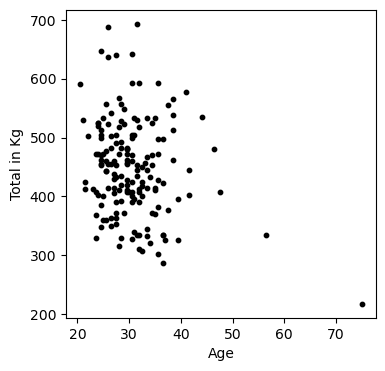

In [17]:
#sanity checking the variables under study
MaxValues = df.max()
print(MaxValues)
MinValues = df.min()
print(MinValues)

#scatter plot (bodyweight)
plt.figure(figsize=(4, 4)) 
plt.scatter(df['BodyweightKg'], df['TotalKg'], color='black', s=10) 
plt.xlabel('Bodyweight in Kg')
plt.ylabel('Total in Kg')

#scatter plot (age)
plt.figure(figsize=(4, 4)) 
plt.scatter(df['Age'], df['TotalKg'], color='black', s=10) 
plt.xlabel('Age')
plt.ylabel('Total in Kg')

#correlation 
pd.options.display.float_format = '{:.2f}'.format
df.corr(method='pearson', min_periods=1, numeric_only=True)

In [ ]:
#tight plot
x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)
y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].plot(x1, y1)
axes[1].plot(x2, y2)
fig.tight_layout()

In [6]:
#setting features and labels
features = []
labels = []
X = df[['BodyweightKg', 'Age']]
y = df['TotalKg']


feature = X.to_numpy()
features.append(feature)
label = y.to_numpy()
labels.append(label)

#X = np.array(features).reshape(-1,1) 
#y = np.array(labels).reshape(-1,)

In [7]:
#split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print(X_test.shape)
print(X_train.shape)

(34, 2)
(132, 2)


In [8]:
#collect errors

stats = []

In [9]:
#run linear regression with n-fold cv

cv = KFold(n_splits=len(X_train), shuffle=True, random_state = 1)

model = LinearRegression().fit(X_train,y_train)

scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
y_train_pred = model.predict(X_train)

scores = -scores
mean_error = np.mean(scores)

train_error = mean_squared_error(y_train, y_train_pred)

stats.append([1, train_error, mean_error])

print("w1, w2 = ", model.coef_)   # print the learnt w1
print("w0 = ",model.intercept_) # print the learnt w0
print("Training error (MSE): ", train_error)
print("K-fold cross validation error (MSE): ",mean_error)

w1, w2 =  [ 2.94402473 -3.23210488]
w0 =  348.27037323806826
Training error (MSE):  2888.5007201075914
K-fold cross validation error (MSE):  3041.635351186651


In [10]:
#run polynomial regression with n-fold cv
degrees = [2,3,4,5]
cv_poly = KFold(n_splits=len(X_train), shuffle=True, random_state = 1)

for i in range(len(degrees)):
    print("Degree: ", degrees[i])
    
    poly = PolynomialFeatures(degree=degrees[i])
    X_poly = poly.fit_transform(X_train)
    poly_model = LinearRegression().fit(X_poly,y_train)
    
    y_poly_train_pred = poly_model.predict(X_poly)
    poly_train_error = mean_squared_error(y_poly_train_pred, y_train)
    
    scores = cross_val_score(poly_model, X_poly, y_train, cv=cv_poly, scoring='neg_mean_squared_error')
    scores = -scores
    mean_error = np.mean(scores)
    
    stats.append([degrees[i], poly_train_error, mean_error])
    
    #print("Coefficients = ", poly_model.coef_)  
    #print("w0 = ",poly_model.intercept_) 
    print("Training error (MSE): ", poly_train_error)
    print("K-fold cross validation error (MSE): ",mean_error)

    #plot the regression
    #X_fit = np.linspace(40, 160)  
    #plt.plot(X_fit, poly_model.predict(poly.transform(X_fit.reshape(-1, 1))), label="Model", color="red")  
    #plt.scatter(X, y, color="black", s=10, label="datapoints")    
    #plt.xlabel('Bodyweigth in Kg')    
    #plt.ylabel('Total in Kg')
    #plt.legend(loc="best")   
    #plt.title('Polynomial degree = {}\n Mean absolute error = {:.5}'.format(degrees[i], mean_error)) 
    #plt.show()  

Degree:  2
Training error (MSE):  2608.9260762965455
K-fold cross validation error (MSE):  2844.979958788998
Degree:  3
Training error (MSE):  2500.219457982768
K-fold cross validation error (MSE):  5103.17807199464
Degree:  4
Training error (MSE):  2352.9115094928993
K-fold cross validation error (MSE):  4014.898160976816
Degree:  5
Training error (MSE):  2083.762148181775
K-fold cross validation error (MSE):  5057308.273680753


In [11]:
#print stats
table = pd.DataFrame(stats, columns = ['polynomial degree', 'training error', 'validation error'])
pd.options.display.float_format = '{:.1f}'.format
print(" Loss of linear and polynomial regressions:")
print(table.to_string(index=False))

 Loss of linear and polynomial regressions:
 polynomial degree  training error  validation error
                 1          2888.5            3041.6
                 2          2608.9            2845.0
                 3          2500.2            5103.2
                 4          2352.9            4014.9
                 5          2083.8         5057308.3


In [12]:
#random forests
cv = KFold(n_splits=len(X_train), shuffle=True, random_state = 1)

model = RandomForestRegressor(max_depth=3, random_state=0)
model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
y_train_pred = model.predict(X_train)

scores = -scores
mean_error = np.mean(scores)

forest_train_error = mean_squared_error(y_train, y_train_pred)

print("Training error (MSE): ", forest_train_error)
print("K-fold cross validation error (MSE): ", mean_error)


Training error (MSE):  1984.2094403417261
K-fold cross validation error (MSE):  3183.1105137554837


In [13]:
#test model

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly_model = LinearRegression().fit(X_poly,y_train)

X_poly_test = poly.fit_transform(X_test)
y_poly_pred = poly_model.predict(X_poly_test)

test_mae_error = mean_absolute_error(y_test, y_poly_pred)
test_mse_error = mean_squared_error(y_test, y_poly_pred)



In [14]:
#print stats
pd.options.display.float_format = '{:.4f}'.format

intercept = poly_model.intercept_
coefficients = poly_model.coef_
coefs = pd.DataFrame(coefficients)

mean_total = mean(df['TotalKg'])

print("Intercept: {:.2f}".format(intercept))
print("Coefficients:")
print()
print(coefs.to_string(index=False, header=False))
print()

print("Test error (MAE): {:.2f}".format(test_mae_error))
print("Test error (MSE): {:.2f}".format(test_mse_error))
print()

print('Mean of TotalKg: {:.2f}'.format(mean_total))

Intercept: 259.37
Coefficients:

 0.0000
 6.0266
-5.9972
-0.0248
 0.0403
 0.0058

Test error (MAE): 40.64
Test error (MSE): 2994.11

Mean of TotalKg: 448.64
